In [1]:
import os
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback, EarlyStoppingCallback, ReduceLROnPlateauCallback
from tqdm.notebook import tqdm as tqdm
import json

with open("../user_config.json") as config:
    path_dict = json.load(config)['data_paths']
    video_path = path_dict['video_path']
    IMAGE_DIR = path_dict['large_faces']
print("Videos: " + video_path)

Videos: /mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/data


In [2]:
df = pd.read_csv('../data/metadata_tr_val_split_folds.csv')
df = df[df['split']=='1st_level']
df = df[df['first_person_label']>-1]
df = df[df['cv_fold']<5]
df['isValFold'] = df['cv_fold'] == 2
df.head()

,index,label,split,isVal,cv_fold,person_count,first_person_label,second_person_label,first_person_frame_labels,second_person_frame_labels,original,version,isValFold
0,gmuagvvcen.mp4,FAKE,1st_level,False,3,1,3.0,NaN,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, ...",NaN,xyioxposka.mp4,2020-02-17,False
1,nlbejgudfx.mp4,FAKE,1st_level,False,1,1,3.0,NaN,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,acguxjvmju.mp4,2020-02-17,False
2,smptxlklxc.mp4,REAL,1st_level,False,0,1,0.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NaN,2020-02-17,False
3,xmodyeeaxr.mp4,FAKE,1st_level,False,1,1,1.0,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ...",NaN,ptpwappdyx.mp4,2020-02-17,False
4,hvxrsfgvyi.mp4,FAKE,1st_level,False,2,2,2.0,0.0,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",qelncdmypn.mp4,2020-02-17,True


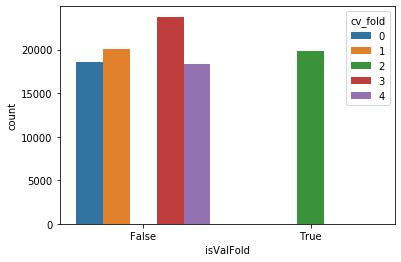

In [3]:
sns.countplot(x='isValFold',hue='cv_fold',data=df)

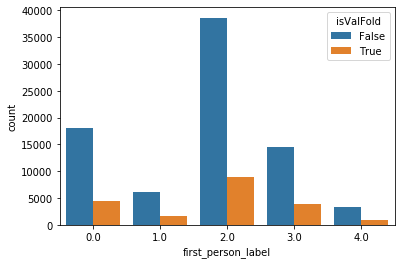

In [4]:
sns.countplot(x='first_person_label',hue='isValFold',data=df)

Get sampled real-fake face pairs.

In [5]:
from util.ImageSampling import getBalancedImageDataFrame

sampled_df = getBalancedImageDataFrame(IMAGE_DIR,df)

In [6]:
# in case we have to restart this notebook

sampled_df.to_csv('../tmp/sampled_df.csv',index=False)
#sampled_df = pd.read_csv('../tmp/sampled_df.csv')

In [7]:
sampled_df.tail()

,path,label,isValFold
432727,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/large_fa...,3,False
432728,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/large_fa...,0,False
432729,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/large_fa...,2,False
432730,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/large_fa...,0,False
432731,/mnt/945C2D6E5C2D4BF4/Kaggle/DeepFake/large_fa...,3,False


In [6]:
# remove directory path from path
sampled_df['path'] = [pth.replace(IMAGE_DIR + '/','') for pth in sampled_df['path'].values]
sampled_df.head()

,path,label,isValFold
0,aflyrowbiw_0_2.png,0,False
1,usidlfjmyo_0_2.png,4,False
2,iezlgezozt_0_15.png,0,False
3,diftwenggi_0_15.png,3,False
4,hqtepxaeqx_0_5.png,0,False


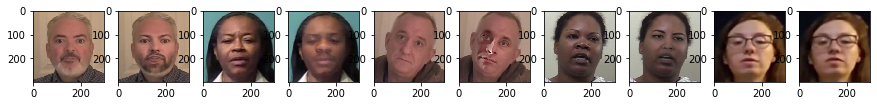

In [7]:
# test that the samples are paired and in order
offset=1048
n_samples = 10

f,ax=plt.subplots(1,n_samples,figsize=(15,15*n_samples))
for i in range(n_samples):
    img_path = os.path.join(IMAGE_DIR,sampled_df.iloc[i+offset]['path'])
    ax[i].imshow(cv2.cvtColor(cv2.imread(str(img_path)),cv2.COLOR_BGR2RGB))

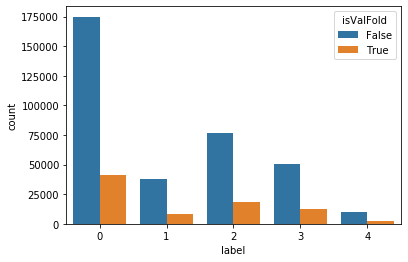

In [8]:
sns.countplot(x='label',hue='isValFold',data=sampled_df)

Change multiclass label back to real/fake binary classes.

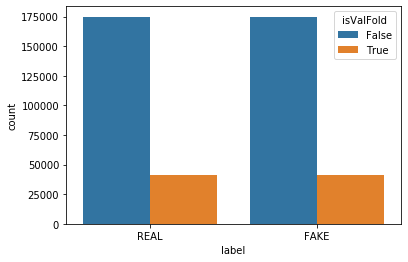

In [9]:
sampled_df['label'] = np.where(sampled_df['label'] > 0, 'FAKE', 'REAL')
sns.countplot(x='label',hue='isValFold',data=sampled_df)

# Train

In [12]:
%load_ext autoreload
%autoreload 2

In [10]:
from util.fastaiAugmentations import JPEGAugment, HueSaturationValueAugment

In [11]:
tfms = get_transforms(max_zoom=1.4,#1.0, 
                      max_rotate=10,#0, 
                      max_warp=0.1,#0,
                      max_lighting=0.4,
                      xtra_tfms=[JPEGAugment(p=0.7),HueSaturationValueAugment(p=0.2)]) # no zoom, rotate or warp because of the reflect padding
data = (ImageDataBunch.from_df(path=IMAGE_DIR, df=sampled_df)
        .split_from_df('isValFold')
       .label_from_df('label')
       .transform(tfms)
       .databunch(bs=8)
       .normalize(stats=imagenet_stats))

# don't shuffle to keep the ordered real-fake pairs in the same batches
data.train_dl = data.train_dl.new(shuffle=False)

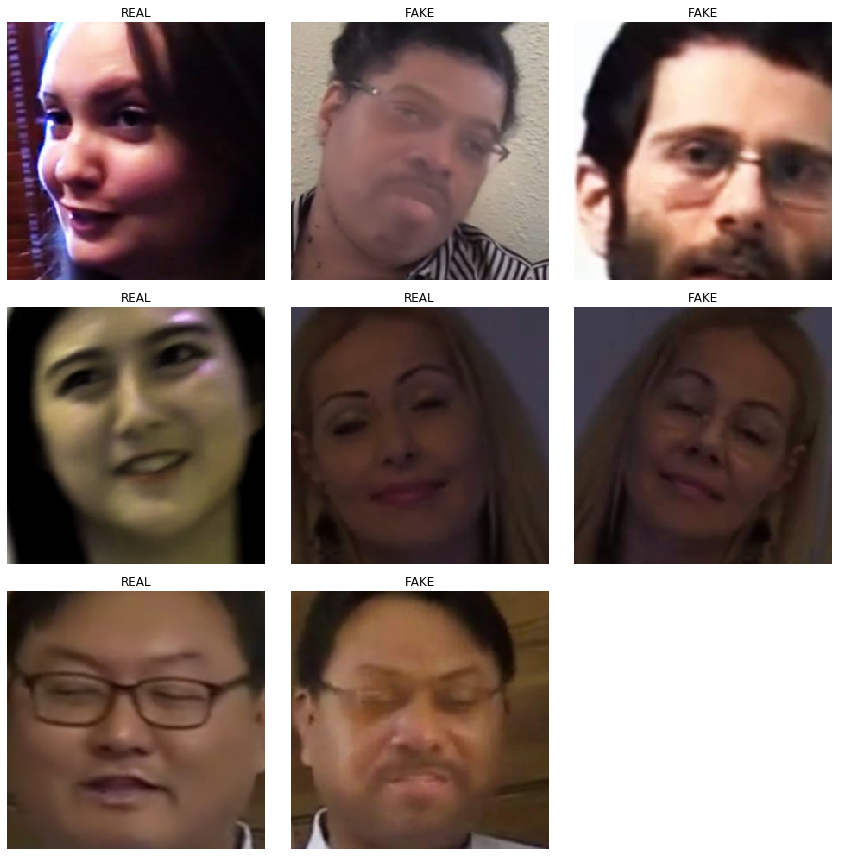

In [14]:
data.show_batch(5)

In [12]:
from util.PretrainedModels import se_resnext50_32x4d

In [13]:
from fastai.layers import LabelSmoothingCrossEntropy

In [17]:
cbs = [ShowGraph]

learn =  cnn_learner(data,
                     se_resnext50_32x4d,
                     pretrained=True,
                     metrics=[accuracy, error_rate], 
                     ps=0.6,
                     callback_fns=cbs,
                     loss_func=LabelSmoothingCrossEntropy()).mixup()

In [18]:
learn.freeze() # this leaves only the head for training
len(learn.layer_groups)

2

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


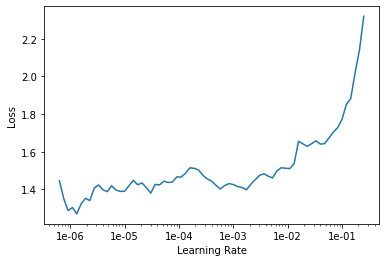

In [19]:
learn.lr_find()
learn.recorder.plot()

## Train head only

Start with one-cycle.

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.515902,0.472223,0.813845,0.186155,1:31:36


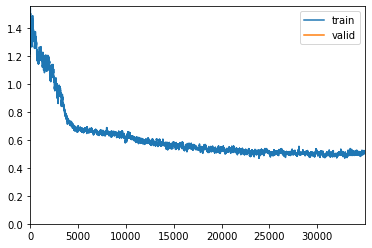

In [20]:
learn.fit_one_cycle(1, 8e-4)

## Train the whole model

Use reduce-lr-on-plateau and train as long as the `valid_loss` improves. Save only the best model.

In [21]:
learn.unfreeze() #train all layers

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.446000,0.401320,0.872544,0.127456,2:14:11
1,0.432068,0.373695,0.895095,0.104905,2:14:06
2,0.402972,0.355566,0.906636,0.093364,2:13:41
3,0.386157,0.365099,0.902452,0.097548,2:13:36
4,0.383447,0.379271,0.906741,0.093259,2:13:36
5,0.358487,0.385919,0.907693,0.092307,2:13:35


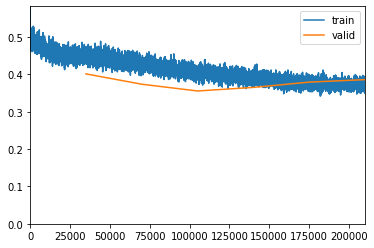

Better model found at epoch 0 with accuracy value: 0.8725435137748718.
Better model found at epoch 1 with accuracy value: 0.8950954079627991.
Better model found at epoch 2 with accuracy value: 0.9066356420516968.
Better model found at epoch 4 with accuracy value: 0.9067413806915283.
Better model found at epoch 5 with accuracy value: 0.9076930284500122.


In [22]:
n_epochs = 6
lrs = [1e-4,8e-4] # use different lr for different layer groups

save_cb = SaveModelCallback(learn,
                            every='improvement', 
                            monitor='accuracy', 
                            name='best')
reduce_lr_cb = ReduceLROnPlateauCallback(learn,
                                         monitor='valid_loss',
                                         patience=0,
                                         factor=0.2,
                                         min_delta=0.01,
                                         min_lr=0.000001)
early_stop_cb = EarlyStoppingCallback(learn,
                                      patience=3)

learn.fit_one_cycle(n_epochs, lrs, callbacks=[save_cb])
                                    #reduce_lr_cb, 
                                    #early_stop_cb])

# Export the model

In [23]:
# load best
_= learn.load('best')

In [24]:
if not os.path.exists('../models/large_face_classifier'):
    os.mkdir('../models/large_face_classifier')
os.mkdir('../models/large_face_classifier/2020_03_12-f2')

In [25]:
learn.export(file="/mnt/945C2D6E5C2D4BF4/Kaggle/deepfake-video-detection/models/large_face_classifier/2020_03_12-f2/export.pkl")

# Error analysis

In [26]:
interp = ClassificationInterpretation.from_learner(learn)

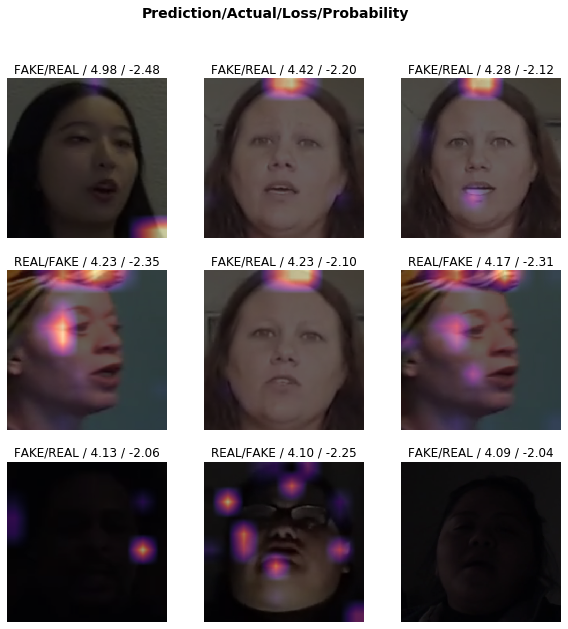

In [27]:
interp.plot_top_losses(9, figsize=(10,10), heatmap=True)

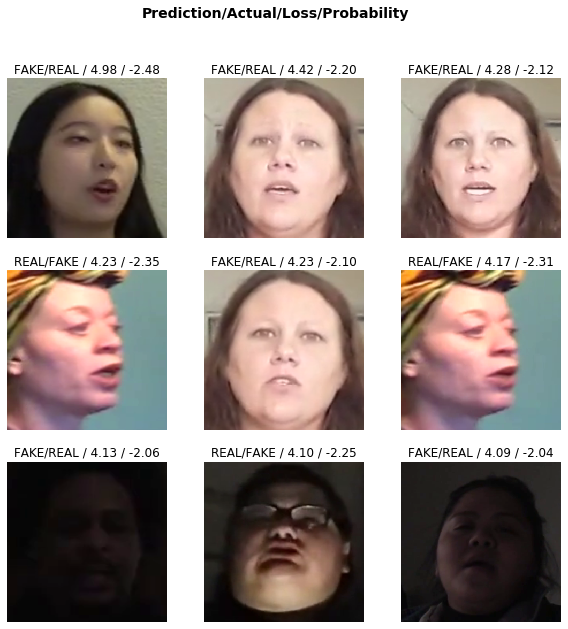

In [28]:
interp.plot_top_losses(9, figsize=(10,10), heatmap=False)

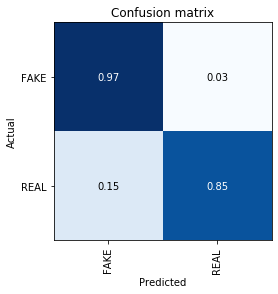

In [29]:
interp.plot_confusion_matrix(normalize=True)

## Plot some random samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


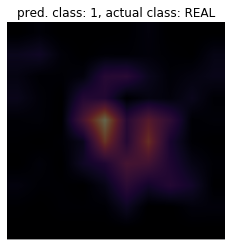

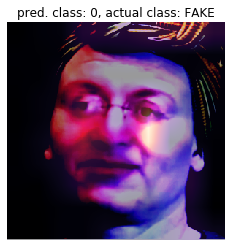

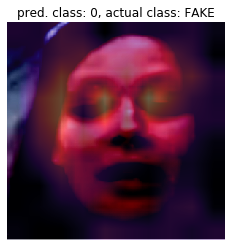

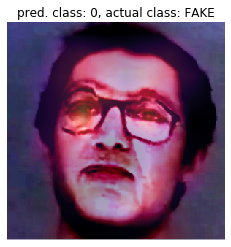

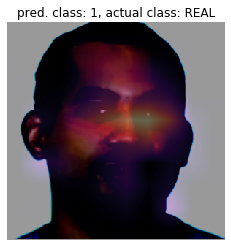

In [30]:
import random
for i in range(5):
    interp.GradCAM(random.randint(0,1000))

In [31]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tqdm
from fastai.vision import *

def getFrameLabel(df, df_index, frame_index, person_index=0):
        # get array of frame labels from the dataframe
        frame_lbl_col = 'first_person_frame_labels' if person_index==0 else 'second_person_frame_labels'
        frame_labels = df.loc[df_index,frame_lbl_col]
        
        # check for nan
        if frame_labels == np.nan:
            return np.nan
        
        lbls_int = [int(lbl) for lbl in str(frame_labels).replace('[','').replace(']','').replace(' ','').split(',')]
        return lbls_int[frame_index]
    
def extractIdFromPath(pth):
    parts = pth.split('/')[-1].split('_')
    return parts[0] + '.mp4', int(parts[2].replace('.png',''))
    
def getGtsNPreds(interp):
    ys = []
    preds = []
    for (pth, pred_tensor) in tqdm(zip(list(interp.data.valid_ds.items),list(interp.preds)),total=len(interp.data.valid_ds.items)):
        pred = pred_tensor[1].numpy() > 0.5
        img_id, frame_index = extractIdFromPath(pth)
        df_index = df[df['index']==img_id].index.values[0]
        frame_lbl = getFrameLabel(df, df_index, frame_index)
        ys.append(frame_lbl)
        preds.append(frame_lbl if (pred==(frame_lbl==0)) else int(not pred))
    return ys, preds

In [32]:
ys, preds = getGtsNPreds(interp)

In [33]:
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(ys,preds)

In [34]:
confusion_mat

array([[26526,  6604,     0,     0,     0],
       [  385,  6245,     0,     0,     0],
       [  219,     0, 14703,     0,     0],
       [   54,     0,     0,  9921,     0],
       [   47,     0,     0,     0,  1499]])

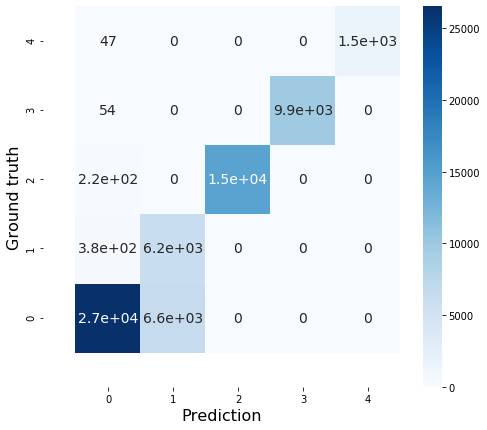

Real type 0 REAL/FAKE binary classification accuracy 80.1 %
Fake type category 1 REAL/FAKE binary classification accuracy 94.2 %
Fake type category 2 REAL/FAKE binary classification accuracy 98.5 %
Fake type category 3 REAL/FAKE binary classification accuracy 99.5 %
Fake type category 4 REAL/FAKE binary classification accuracy 97.0 %


In [35]:
df_cm = pd.DataFrame(confusion_mat, index = list(range(5)),
                  columns = list(range(5)))
plt.figure(figsize = (8,7))
sns.heatmap(df_cm, annot=True, cmap='Blues',annot_kws={"size": 14})
plt.xlim(-0.5,5)
plt.ylim(-0.5,5)
plt.ylabel('Ground truth',fontsize=16)
plt.xlabel('Prediction',fontsize=16)
plt.show()

for lbl_ind in range(5):
    right = confusion_mat[lbl_ind][lbl_ind]
    wrong = confusion_mat[lbl_ind][0 if lbl_ind > 0 else 1]
    print('{2} {0} REAL/FAKE binary classification accuracy {1:.1f} %'.format(lbl_ind,
                                                                              100*right/(right+wrong),
                                                                              'Fake type category' if lbl_ind > 0 else 'Real type'))

# Predictions

After using LabelSmoothingCrossEntropy, our predictions are not softmax outputs so it's useful to add a softmax function to the production logic and even better if we can detect automatically if softmax has already been applied. 

In [14]:
learn = load_learner("/mnt/945C2D6E5C2D4BF4/Kaggle/deepfake-video-detection/models/large_face_classifier/2020_03_12-f2/")

In [15]:
learn.data = data

In [16]:
test_batch = learn.data.norm(data.one_batch())[0].cuda()

In [38]:
preds = learn.pred_batch(ds_type=DatasetType.Test,batch=(test_batch,None))#.numpy()
preds

tensor([[-1.0524,  0.8863],
        [ 1.3824, -1.2815],
        [-1.2607,  1.0959],
        [ 1.5885, -1.5062],
        [-1.1775,  1.0197],
        [ 1.0696, -0.9954],
        [-1.3289,  1.1822],
        [ 1.3954, -1.2919]])

In [21]:
import torch.functional as F
import torch

In [39]:
softmax_preds = torch.softmax(preds,dim=1)
softmax_preds

tensor([[0.1258, 0.8742],
        [0.9349, 0.0651],
        [0.0865, 0.9135],
        [0.9567, 0.0433],
        [0.1000, 0.9000],
        [0.8875, 0.1125],
        [0.0751, 0.9249],
        [0.9363, 0.0637]])

In [48]:
def isSoftmaxOutput(preds, eps=1e-6):
    mean = torch.mean(torch.sum(preds,dim=1))
    return (torch.abs(mean-1.0) < eps).item()

In [49]:
isSoftmaxOutput(preds)

False

In [50]:
isSoftmaxOutput(softmax_preds)

True